In [1]:
import pandas as pd
import numpy as np
import sqlite3
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
EXPERIMENT_NAME = 'P3856'

#### prepare the TFD/E results

In [3]:
# load the results
EXPERIMENT_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/{}'.format(EXPERIMENT_NAME)
RESULTS_DB_NAME = '{}/summarised-results/results.sqlite'.format(EXPERIMENT_DIR)
db_conn = sqlite3.connect(RESULTS_DB_NAME)
results_df = pd.read_sql_query("select * from sequences", db_conn)
db_conn.close()

In [4]:
len(results_df)

23295

In [5]:
# convert the identifications from JSON to Python objects
results_df['identifications_d'] = results_df.apply(lambda row: json.loads(row.identifications), axis=1)

In [6]:
# separate some key metrics into separate columns
results_df['id_perc_q_value'] = results_df.apply(lambda row: row.identifications_d['perc_q_value'], axis=1)
results_df['id_count_all_runs'] = results_df.apply(lambda row: len(row.identifications_d['run_names']), axis=1)
results_df['id_count_human_only_runs'] = results_df.apply(lambda row: sum('YHE010' in s for s in row.identifications_d['run_names']), axis=1)

In [7]:
# remove the results that couldn't be extracted or were not classified as a target
results_df = results_df[results_df.extractions.notnull()].copy()

In [8]:
# convert from JSON to Python objects
results_df['extractions_l'] = results_df.apply(lambda row: json.loads(row.extractions), axis=1)

In [9]:
# separate some key metrics into separate columns
results_df['ext_count_all_runs'] = results_df.apply(lambda row: len(row.extractions_l), axis=1)
results_df['ext_count_human_only_runs'] = results_df.apply(lambda row: sum('YHE010' in s['run_name'] for s in row.extractions_l), axis=1)

In [10]:
results_df.sample(n=3)

,sequence,charge,identifications,extractions,identifications_d,id_perc_q_value,id_count_all_runs,id_count_human_only_runs,extractions_l,ext_count_all_runs,ext_count_human_only_runs
9476,IIHHSGSMDQR,2,"{""perc_q_value"": 3.817231e-06, ""run_names"": [""...","[{""run_name"": ""P3856_YHE211_6_Slot1-1_1_5109"",...","{'perc_q_value': 3.817231e-06, 'run_names': ['...",0.000004,1,0,"[{'run_name': 'P3856_YHE211_6_Slot1-1_1_5109',...",24,6
13718,MTELADVFSGVKPLTR,2,"{""perc_q_value"": 1.7004295999999998e-05, ""run_...","[{""run_name"": ""P3856_YHE211_6_Slot1-1_1_5109"",...","{'perc_q_value': 1.7004295999999998e-05, 'run_...",0.000017,3,1,"[{'run_name': 'P3856_YHE211_6_Slot1-1_1_5109',...",30,10
6587,GAIQFVTQYQHSSGQR,2,"{""perc_q_value"": 3.817231e-06, ""run_names"": [""...","[{""run_name"": ""P3856_YHE211_6_Slot1-1_1_5109"",...","{'perc_q_value': 3.817231e-06, 'run_names': ['...",0.000004,9,7,"[{'run_name': 'P3856_YHE211_6_Slot1-1_1_5109',...",29,10


In [11]:
# count the number of unique peptide identifications in each run
counts_d = {}
for row in results_df.itertuples():
    for run_name in row.identifications_d['run_names']:
        if run_name not in counts_d:
            counts_d[run_name] = 0
        counts_d[run_name] += 1

In [12]:
# sort the run names by group then run number within the group
sorted_counts_l = []
for k in sorted(list(counts_d.keys()), key=lambda x: ( x.split('_')[1], int(x.split('_')[2]) )):
    short_run_name = '_'.join(k.split('_Slot')[0].split('_')[1:])
    sorted_counts_l.append((short_run_name, counts_d[k]))
sorted_counts_df = pd.DataFrame(sorted_counts_l, columns=['run_name','count'])

#### prepare the MaxQuant results

In [13]:
mq_results_df = pd.read_csv('{}/evidence-P3856.txt'.format(EXPERIMENT_DIR), sep='\\t', engine='python')

In [14]:
# remove decoys, which are indicated by a '+' in the Reverse column
mq_results_df = mq_results_df[pd.isna(mq_results_df.Reverse)]
# remove identifications with no intensity
mq_results_df = mq_results_df[(mq_results_df.Intensity > 0)]
# remove potential contaminants
mq_results_df = mq_results_df[pd.isna(mq_results_df['Potential contaminant'])]
# remove identifications with mass error more than +/- 5 ppm
mq_results_df = mq_results_df[np.abs(mq_results_df['Mass error [ppm]']) <= 5.0]

In [15]:
# definition of uniqueness in MaxQuant output with MBR on
unique_peptide_key = ['Sequence','Modifications','Charge']

In [16]:
# count the number of unique peptide identifications in each run
mq_counts_d = {}
for group_name,group_df in mq_results_df.groupby(unique_peptide_key, as_index=False):
    df = group_df[(group_df.Type == 'TIMS-MULTI-MSMS')]
    for run_name in df['Raw file'].unique():
        if run_name not in mq_counts_d:
            mq_counts_d[run_name] = 0
        mq_counts_d[run_name] += 1

In [17]:
mq_sorted_counts_l = []
for k in sorted(mq_counts_d.keys()):
    short_run_name = '_'.join(k.split('_Slot')[0].split('_')[1:3])
    mq_sorted_counts_l.append((short_run_name, mq_counts_d[k]))
mq_sorted_counts_df = pd.DataFrame(mq_sorted_counts_l, columns=['run_name','count'])

#### prepare the MSFragger results

In [18]:
# use the Fragger analysis without MBR because there doesn't seem to be a way of distinguishing between identification and matching
fragger_results_df = pd.read_csv('{}/MSstats-without-MBR.csv'.format(EXPERIMENT_DIR), sep=',')


In [19]:
fragger_results_df = fragger_results_df[fragger_results_df.Intensity.notnull()]

In [20]:
fragger_results_df.sample(n=5)

,ProteinName,PeptideSequence,PrecursorCharge,FragmentIon,ProductCharge,IsotopeLabelType,Condition,BioReplicate,Run,Intensity
604224,sp|Q9H074|PAIP1_HUMAN,ELLNALFSNPMDDNLIC[57.0215]AVK,2,NaN,NaN,L,YHE211,4,P3856_YHE211_4_Slot1-1_1_5107,16369.59300
577475,sp|Q96T76|MMS19_HUMAN,VEAEGLAALHSLTAC[57.0215]LSR,2,NaN,NaN,L,YHE010,5,P3856_YHE010_5_Slot1-1_1_5097,13946.29900
351035,sp|P55072|TERA_HUMAN,NAPAIIFIDELDAIAPK,2,NaN,NaN,L,YHE010,5,P3856_YHE010_5_Slot1-1_1_5097,101961.87000
332987,sp|P52272|HNRPM_HUMAN,VMATTGGMGMGPGGPGMITIPPSILNNPNIPNEIIHALQAGR,3,NaN,NaN,L,YHE114,7,P3856_YHE114_7_Slot1-1_1_5121,569.89044
245009,sp|P33327|DHE2_YEAST,ESPQLISNIIHSLYASK,2,NaN,NaN,L,YHE211,9,P3856_YHE211_9_Slot1-1_1_5112,17319.24800


In [21]:
# count the number of unique peptide identifications in each run
fragger_counts_d = {}
for group_name,group_df in fragger_results_df.groupby(['PeptideSequence', 'PrecursorCharge'], as_index=False):
    for run_name in group_df['Run'].unique():
        if run_name not in fragger_counts_d:
            fragger_counts_d[run_name] = 0
        fragger_counts_d[run_name] += 1

In [22]:
# sort the run names by group then run number within the group
sorted_counts_l = []
for k in sorted(list(fragger_counts_d.keys()), key=lambda x: ( x.split('_')[1], int(x.split('_')[2]) )):
    short_run_name = '_'.join(k.split('_Slot')[0].split('_')[1:])
    sorted_counts_l.append((short_run_name, fragger_counts_d[k]))
fragger_sorted_counts_df = pd.DataFrame(sorted_counts_l, columns=['run_name','count'])

#### plot the unique peptide level

In [23]:
merged_df = sorted_counts_df.merge(mq_sorted_counts_df,on='run_name').merge(fragger_sorted_counts_df,on='run_name')
merged_df.rename({'count_x':'count_tfd/e', 'count_y':'count_mq', 'count':'count_fragger'}, axis=1, inplace=True)
merged_df.index = merged_df.run_name

In [24]:
merged_df.sample(n=3)

,run_name,count_tfd/e,count_mq,count_fragger
run_name,,,,
YHE010_6,YHE010_6,8904,9144,11598
YHE114_2,YHE114_2,9054,9425,12232
YHE114_6,YHE114_6,8681,9172,11819


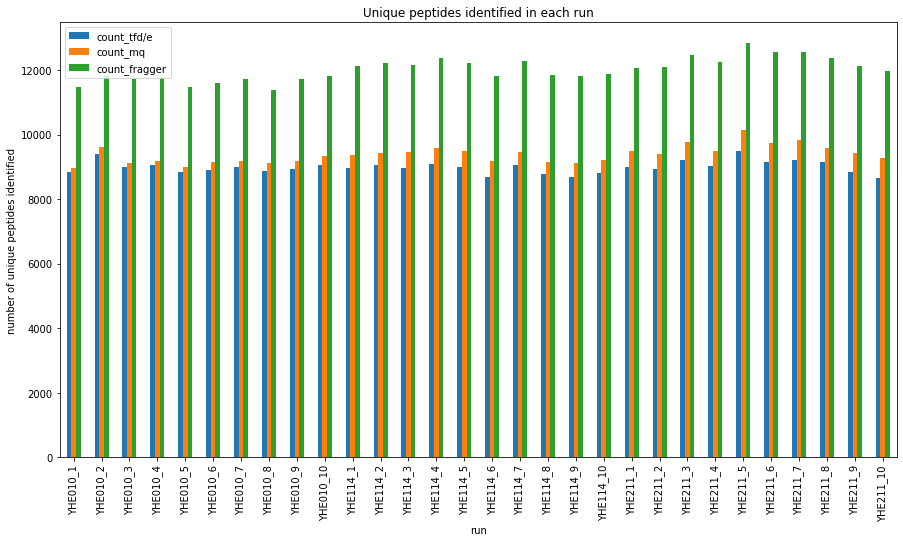

In [25]:
merged_df.plot(kind='bar', figsize=(15,8))
_ = plt.title("Unique peptides identified in each run")
_ = plt.xlabel("run")
_ = plt.ylabel("number of unique peptides identified")

## missing-ness heatmaps

In [26]:
# return True if we can include an extraction from the specified group, given the groups in which it was identified
# need to implement these rules differently for each experiment, probably best with a simple rules parameter file
def extract_from_group(extract_group, identification_run_names_l):
    result = False
    identification_groups_l = list(set([r.split('_')[1] for r in identification_run_names_l]))
    if extract_group == 'YHE010':
        result = extract_group in identification_groups_l
    else:
        result = True
    return result

#### prepare the TFD/E data

In [27]:
# gather the lower intensity decile
results_df.columns

Index(['sequence', 'charge', 'identifications', 'extractions',
       'identifications_d', 'id_perc_q_value', 'id_count_all_runs',
       'id_count_human_only_runs', 'extractions_l', 'ext_count_all_runs',
       'ext_count_human_only_runs'],
      dtype='object')

In [28]:
results_df.iloc[0].extractions_l

[{'run_name': 'P3856_YHE010_9_Slot1-1_1_5101',
  'prob_target': 0.5535360344747312,
  'intensity': 181,
  'inferred': 0}]

In [29]:
sequences_l = []
for row in results_df.itertuples():
    for group_name in ['YHE114','YHE211','YHE010']:
        if extract_from_group(extract_group=group_name, identification_run_names_l=row.identifications_d['run_names']):
            for extraction in row.extractions_l:
                if group_name in extraction['run_name']:
                    short_run_name = '_'.join(extraction['run_name'].split('_Slot')[0].split('_')[1:3])
                    sequences_l.append((row.sequence, row.charge, row.id_perc_q_value, short_run_name, group_name, extraction['intensity']))
sequences_df = pd.DataFrame(sequences_l, columns=['sequence', 'charge', 'id_perc_q_value', 'short_run_name', 'group','intensity'])


In [30]:
sequences_df.sample(n=5)

,sequence,charge,id_perc_q_value,short_run_name,group,intensity
33951,ASAIAQDADQNYDYASNSVILHLDVGDEVFIK,3,0.004938,YHE211_10,YHE211,192
205349,HQDEAVVLSYVNGDR,2,0.000004,YHE010_7,YHE010,1258
415595,SFDPFADTGDDETATSNYIHIR,3,0.000017,YHE211_9,YHE211,644
346070,NLLESYHVPELIK,2,0.000004,YHE211_6,YHE211,2404
42732,AYHEQLTVAEITNACFEPANQMVK,3,0.000004,YHE211_3,YHE211,1624


In [31]:
# find the mean intensity for each peptide in each group
intensities_l = []
for group_name,group_df in sequences_df.groupby(['sequence','charge','group'], as_index=False):
    mean_intensity = group_df.intensity.mean()
    intensities_l.append((group_name[0], group_name[1], group_name[2], mean_intensity))
intensities_df = pd.DataFrame(intensities_l, columns=['sequence', 'charge', 'group', 'group_mean_intensity'])

In [32]:
# sort each group by descending intensity
intensities_df.sort_values(by=['group_mean_intensity'], ascending=False, inplace=True)

In [33]:
intensities_df.tail()

,sequence,charge,group,group_mean_intensity
20271,GVEVVLPVDFIIADAFSADANTK,2,YHE114,68.0
24941,ILNVSHNHISHIPK,2,YHE114,66.0
3021,APCILLYISSFTTDFLAVLVKPTGSLQIRYNLGGTR,4,YHE114,65.0
24320,IHLAQSLHK,2,YHE211,58.0
51198,TPSECLLTPLPPSALPSADDNLK,3,YHE211,25.0


In [34]:
# make a separate DF for each group
yhe010_df = intensities_df[(intensities_df.group == 'YHE010')].copy()
yhe114_df = intensities_df[(intensities_df.group == 'YHE114')].copy()
yhe211_df = intensities_df[(intensities_df.group == 'YHE211')].copy()

In [35]:
# find the lowest-intensity peptides in each group
lower_proportion = 0.1
yhe010_lowest_df = yhe010_df.tail(int(lower_proportion * len(yhe010_df)))
yhe114_lowest_df = yhe114_df.tail(int(lower_proportion * len(yhe114_df)))
yhe211_lowest_df = yhe211_df.tail(int(lower_proportion * len(yhe211_df)))

## TFD/E heatmaps

#### plot YHE010

In [36]:
run_names_l = sorted(list(sequences_df[sequences_df.group == 'YHE010'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [37]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe010_lowest_df.itertuples():
    run_occurences_df = sequences_df[(sequences_df.sequence == row.sequence) & (sequences_df.charge == row.charge) & (sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

In [38]:
occurences_df.head()

,YHE010_1,YHE010_2,YHE010_3,YHE010_4,YHE010_5,YHE010_6,YHE010_7,YHE010_8,YHE010_9,YHE010_10
"VQSSYLHSLLEMGELLK,3",0.000000,8.693487,8.854868,0.000000,0.000000,0.000000,8.400879,9.047124,0.000000,8.758223
"SYGLSVVPEPAGCTPELPGEIIK,2",8.252665,8.816984,8.611025,8.903882,9.052568,8.622052,8.836050,8.727920,8.546894,9.098032
"DSWLDNIDWVK,2",7.651052,8.845490,7.930737,8.344296,9.177420,8.573647,8.778077,10.048487,8.383704,8.366322
"ELEFLSMANVELSSLAR,2",8.144658,8.134426,7.459432,10.005625,7.965784,8.144658,9.296916,7.727920,9.426265,9.025140
"GSGFTVTGGTEELPEEEGGGGSGGR,2",8.826548,8.603626,8.960002,7.876517,7.651052,8.724514,9.262095,9.055282,8.936638,9.000000


Text(0.5, 1, 'Lowest 10% of peptides by intensity for YHE010')

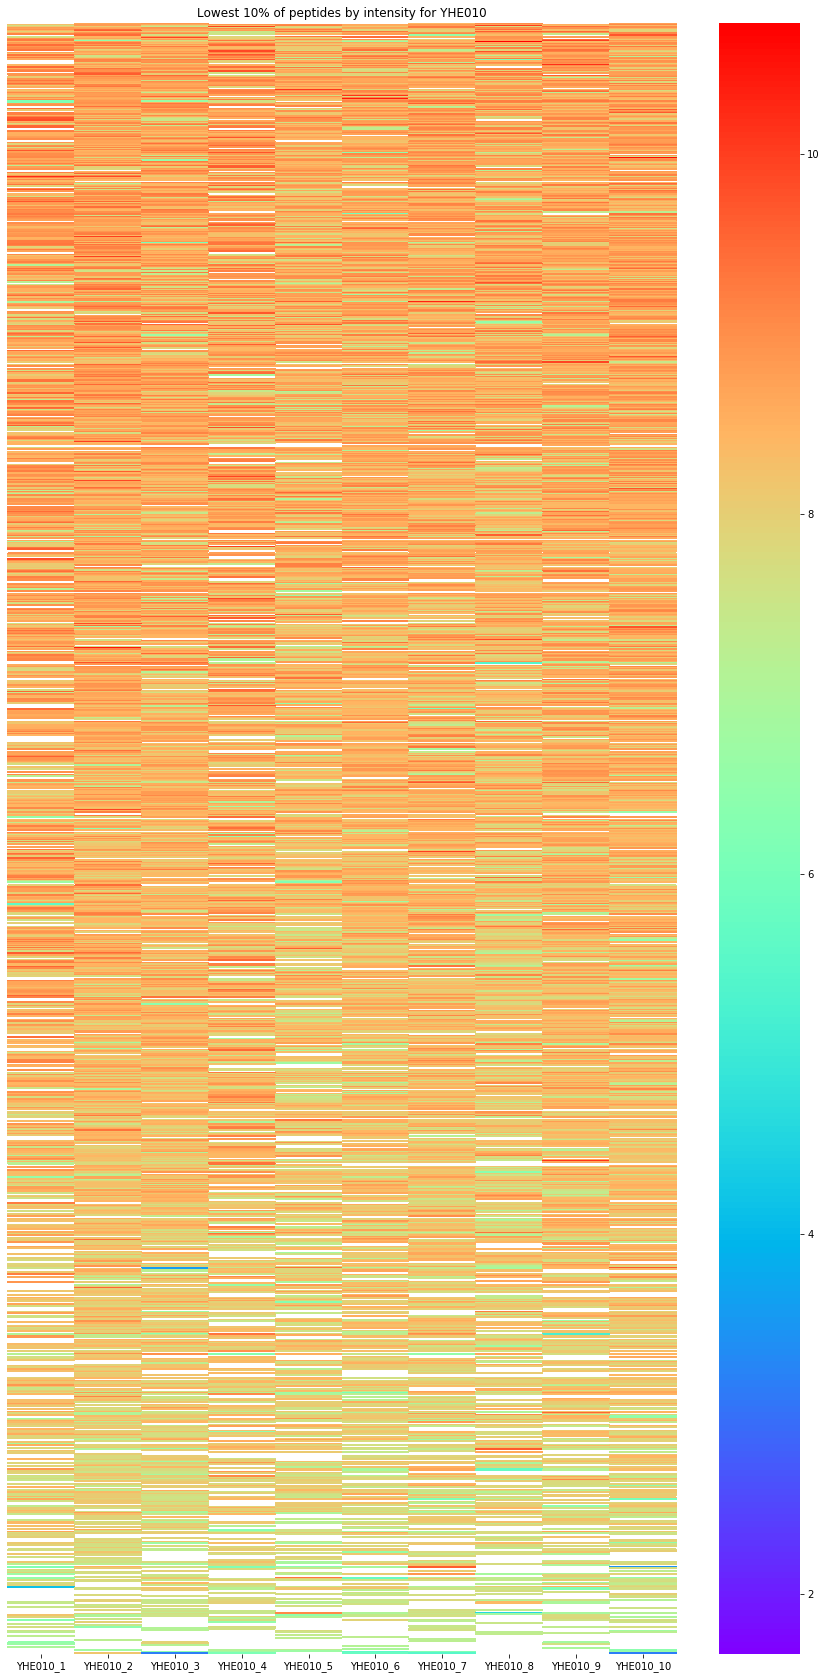

In [39]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap='rainbow', vmin=np.log2(a[a > 0].min()), mask=(occurences_df==0))
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {}% of peptides by intensity for YHE010'.format(int(lower_proportion*100)))

#### plot YHE114

In [40]:
run_names_l = sorted(list(sequences_df[sequences_df.group == 'YHE114'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [41]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe114_lowest_df.itertuples():
    run_occurences_df = sequences_df[(sequences_df.sequence == row.sequence) & (sequences_df.charge == row.charge) & (sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1, 'Lowest 10% of peptides by intensity for YHE114')

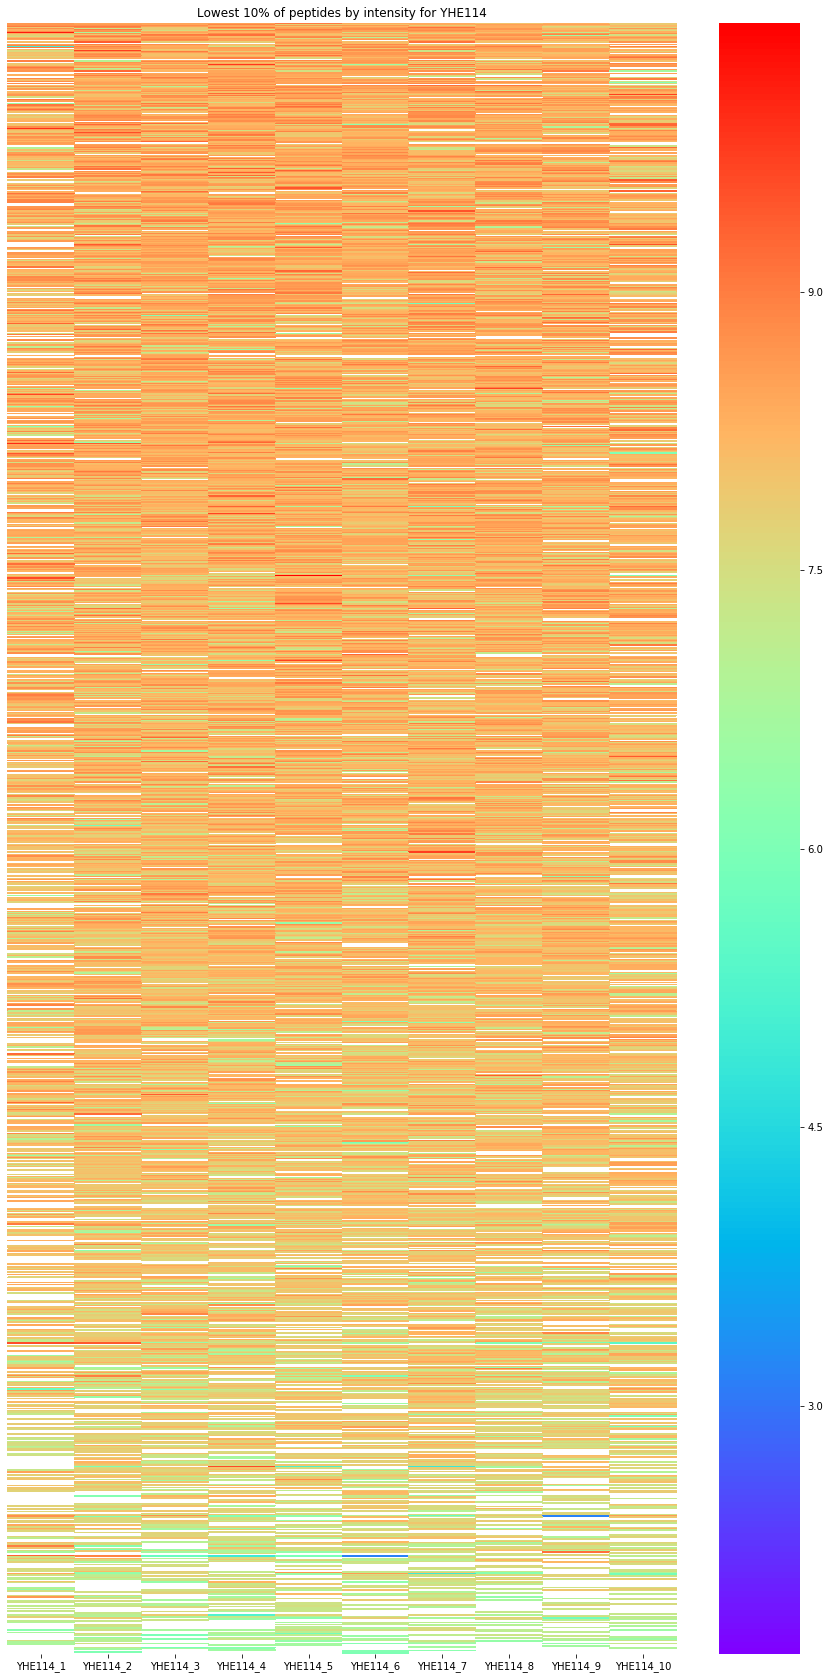

In [42]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap='rainbow', vmin=np.log2(a[a > 0].min()), mask=(occurences_df==0))
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {}% of peptides by intensity for YHE114'.format(int(lower_proportion*100)))

#### plot YHE211

In [43]:
run_names_l = sorted(list(sequences_df[sequences_df.group == 'YHE211'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [44]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe211_lowest_df.itertuples():
    run_occurences_df = sequences_df[(sequences_df.sequence == row.sequence) & (sequences_df.charge == row.charge) & (sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1, 'Lowest 10% of peptides by intensity for YHE211')

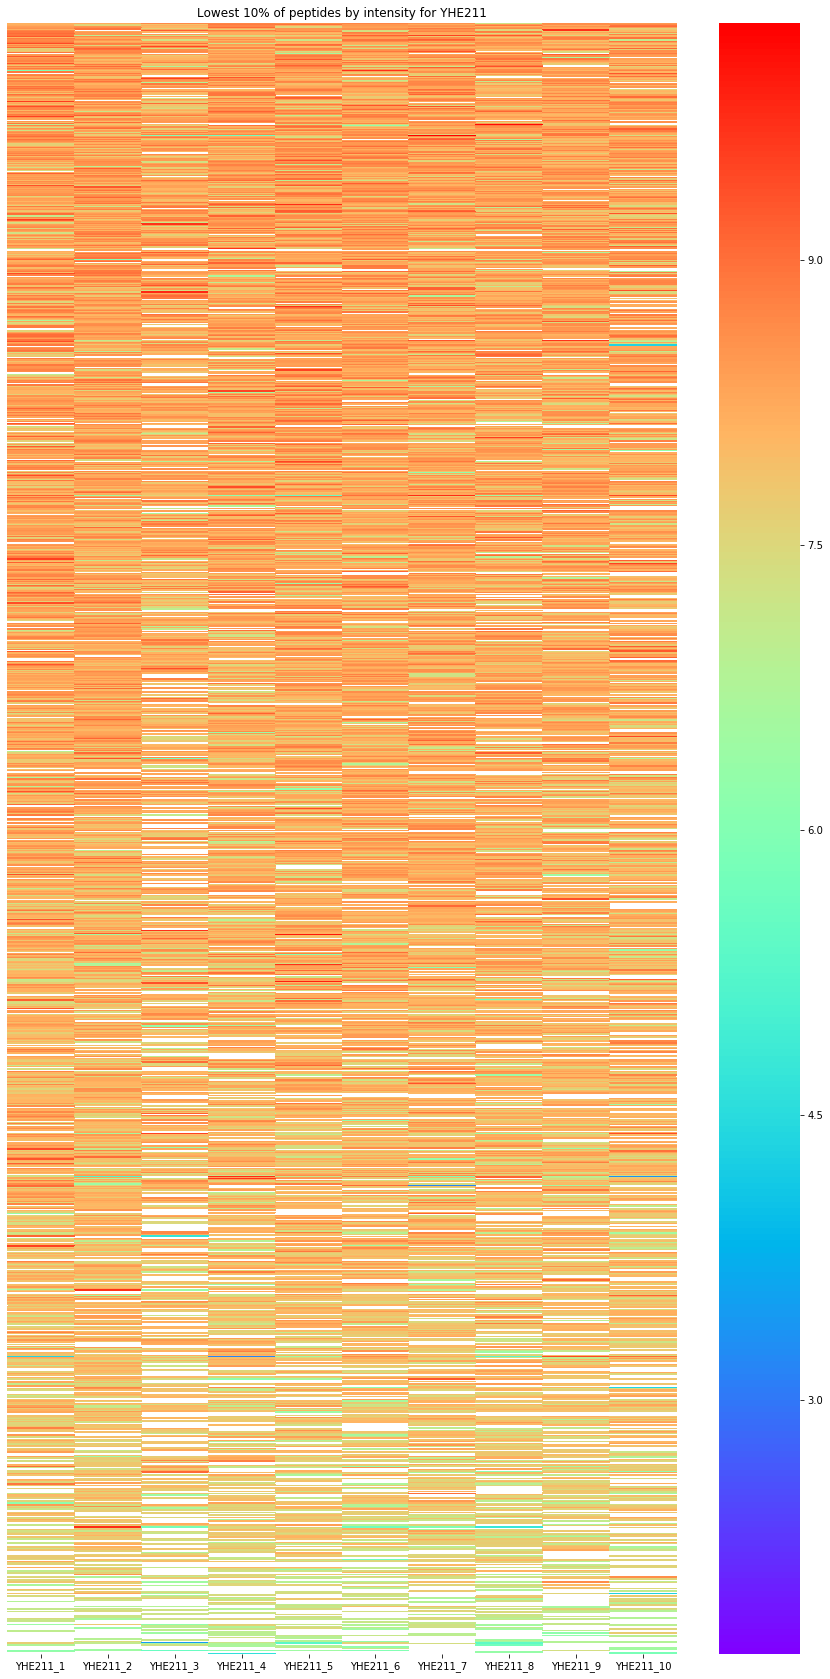

In [45]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap='rainbow', vmin=np.log2(a[a > 0].min()), mask=(occurences_df==0))
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {}% of peptides by intensity for YHE211'.format(int(lower_proportion*100)))

## MaxQuant heatmaps

In [46]:
mq_results_df.columns

Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins', 'Leading proteins', 'Leading razor protein', 'Type',
       'Raw file', 'MS/MS m/z', 'Charge', 'm/z', 'Mass',
       'Uncalibrated - Calibrated m/z [ppm]',
       'Uncalibrated - Calibrated m/z [Da]', 'Mass error [ppm]',
       'Mass error [Da]', 'Uncalibrated mass error [ppm]',
       'Uncalibrated mass error [Da]', 'Max intensity m/z 0', 'Retention time',
       'Retention length', 'Calibrated retention time',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Retention time calibration', 'Ion mobility index',
       'Ion mobility length', '1/K0', '1/K0 length', 'Calibrated 1/K0', 'CCS',
       'Calibrated CCS', 'CCS length', 'Match time difference',
       'Match m/z difference', 'Match K0 difference', 'Match q-value',
       'M

In [47]:
# get one reading for each unique peptide in each run, and count how many identifications and extractions (i.e. 
# matches) across each group. Note that a sequence can be counted as an identification and a match in the same file 
# (i.e. it's given a different score).
mq_sequences_l = []
unique_peptide_key_file = unique_peptide_key + ['Raw file']
for group_name,group_df in mq_results_df.groupby(unique_peptide_key_file, as_index=False):
    identified_in_file = (len(group_df[group_df.Type == 'TIMS-MULTI-MSMS']) > 0)
    short_run_name = '_'.join(group_name[3].split('_Slot')[0].split('_')[1:3])
    grp_name = short_run_name.split('_')[0]
    sorted_df = group_df.sort_values(by=['Intensity'], ascending=False, inplace=False)
    if identified_in_file:
        score = sorted_df.iloc[0]['Score']
    else:
        score = sorted_df.iloc[0]['Match score']
    intensity = sorted_df.iloc[0].Intensity
    mq_sequences_l.append((group_name[0], group_name[1], group_name[2], short_run_name, grp_name, identified_in_file, score, intensity))
mq_sequences_df = pd.DataFrame(mq_sequences_l, columns=['sequence','modifications','charge','short_run_name','group','identified_in_file','score','intensity'])


In [48]:
mq_sequences_df.sample(n=5)

,sequence,modifications,charge,short_run_name,group,identified_in_file,score,intensity
339098,TGCNVLLIQK,Unmodified,2,YHE114_10,YHE114,False,133.860,4139.0
259555,NLILKPGGSLDGMDMLHNFLK,Unmodified,3,YHE211_4,YHE211,True,123.830,41295.0
63842,DVPKPVLNSVQHDNTSANVIPAAAQASLGDGLANALAAR,Unmodified,4,YHE211_2,YHE211,False,47.099,18758.0
241376,MGMGNNYSGGYGTPDGLGGYGR,Unmodified,2,YHE211_9,YHE211,True,287.120,795860.0
216474,LNFSHGTHEYHAETIK,Unmodified,2,YHE211_9,YHE211,True,127.620,88057.0


In [49]:
# find the mean intensity for each peptide in each group
mq_intensities_l = []
for group_name,group_df in mq_sequences_df.groupby(['sequence','modifications','charge','group'], as_index=False):
    mean_intensity = group_df.intensity.mean()
    mq_intensities_l.append((group_name[0], group_name[1], group_name[2], group_name[3], mean_intensity))
mq_intensities_df = pd.DataFrame(mq_intensities_l, columns=['sequence', 'modifications', 'charge', 'group', 'group_mean_intensity'])

In [50]:
# sort each group by descending intensity
mq_intensities_df.sort_values(by=['group_mean_intensity'], ascending=False, inplace=True)

In [51]:
mq_intensities_df.tail()

,sequence,modifications,charge,group,group_mean_intensity
46385,VDNAYWLWTFQGR,Unmodified,2,YHE114,873.45
34372,NYLPLLEPVKPEPK,Unmodified,2,YHE211,869.28
8699,EATWTMSNITAGR,Unmodified,2,YHE010,756.94
3300,AQLAQDGVQLCALDDLDSK,Unmodified,2,YHE114,728.88
27256,LMAPYTPFLTELMYQNLK,Unmodified,2,YHE010,719.49


In [52]:
# make a separate DF for each group
yhe010_df = mq_intensities_df[(mq_intensities_df.group == 'YHE010')].copy()
yhe114_df = mq_intensities_df[(mq_intensities_df.group == 'YHE114')].copy()
yhe211_df = mq_intensities_df[(mq_intensities_df.group == 'YHE211')].copy()

In [53]:
# find the lowest-intensity peptides in each group
lower_proportion = 0.1
yhe010_lowest_df = yhe010_df.tail(int(lower_proportion * len(yhe010_df)))
yhe114_lowest_df = yhe114_df.tail(int(lower_proportion * len(yhe114_df)))
yhe211_lowest_df = yhe211_df.tail(int(lower_proportion * len(yhe211_df)))

#### plot YHE010

In [54]:
run_names_l = sorted(list(mq_sequences_df[mq_sequences_df.group == 'YHE010'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [55]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe010_lowest_df.itertuples():
    run_occurences_df = mq_sequences_df[(mq_sequences_df.sequence == row.sequence) & (mq_sequences_df.modifications == row.modifications) & (mq_sequences_df.charge == row.charge) & (mq_sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1, 'Lowest 10% of peptides by intensity for YHE010 by MaxQuant (N=1613)')

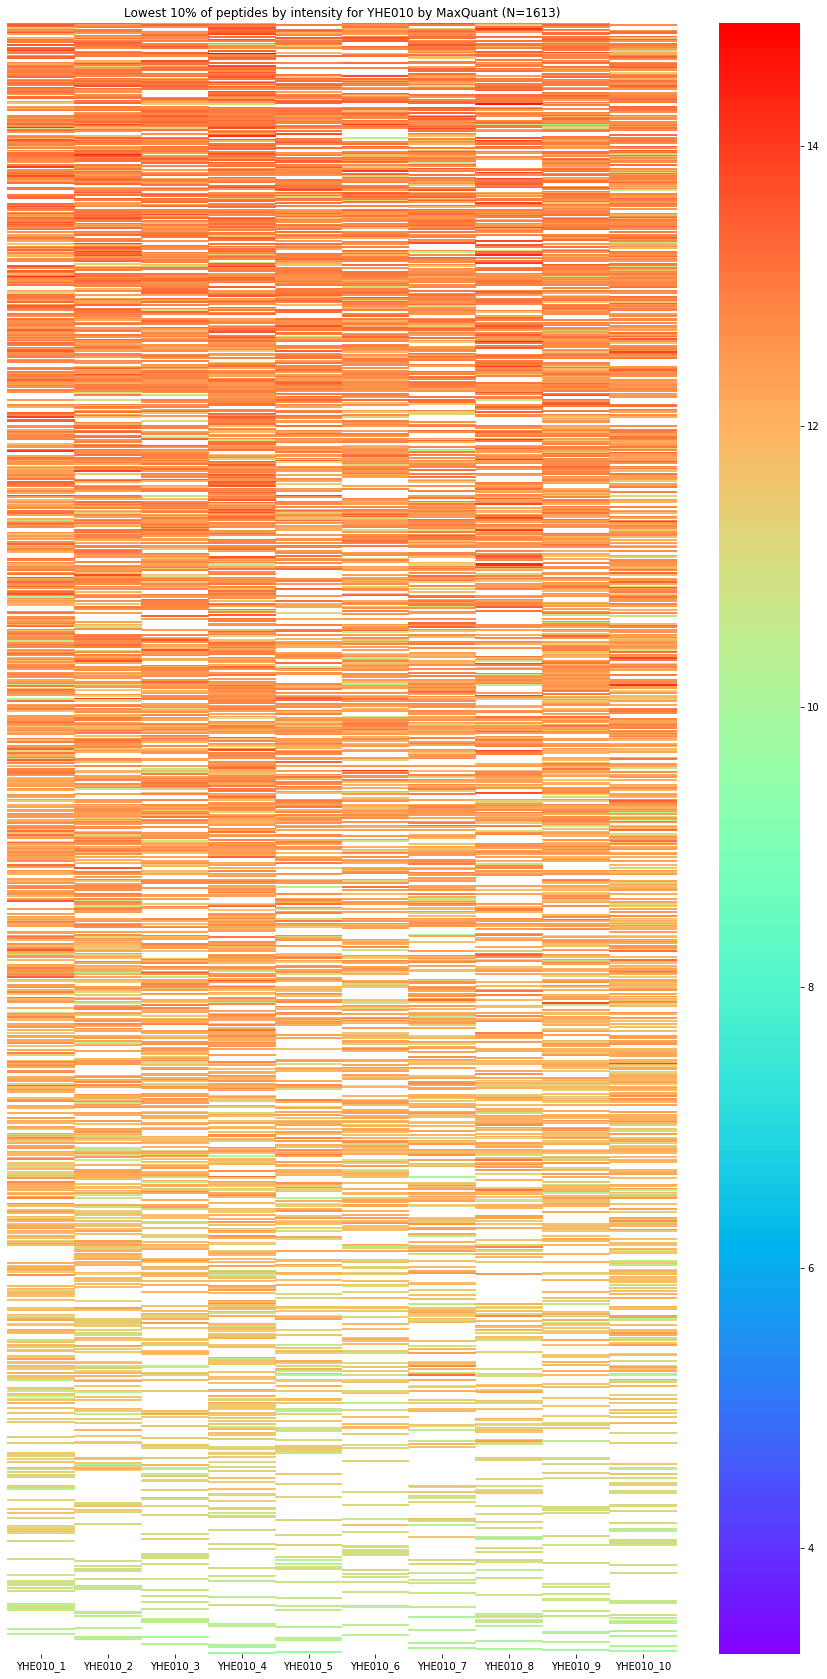

In [56]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap='rainbow', vmin=np.log2(a[a > 0].min()), mask=(occurences_df==0))
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {}% of peptides by intensity for YHE010 by MaxQuant (N={})'.format(int(lower_proportion*100), len(occurences_df)))

#### plot YHE114

In [57]:
run_names_l = sorted(list(mq_sequences_df[mq_sequences_df.group == 'YHE114'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [58]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe114_lowest_df.itertuples():
    run_occurences_df = mq_sequences_df[(mq_sequences_df.sequence == row.sequence) & (mq_sequences_df.modifications == row.modifications) & (mq_sequences_df.charge == row.charge) & (mq_sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1, 'Lowest 10% of peptides by intensity for YHE114 by MaxQuant (N=1811)')

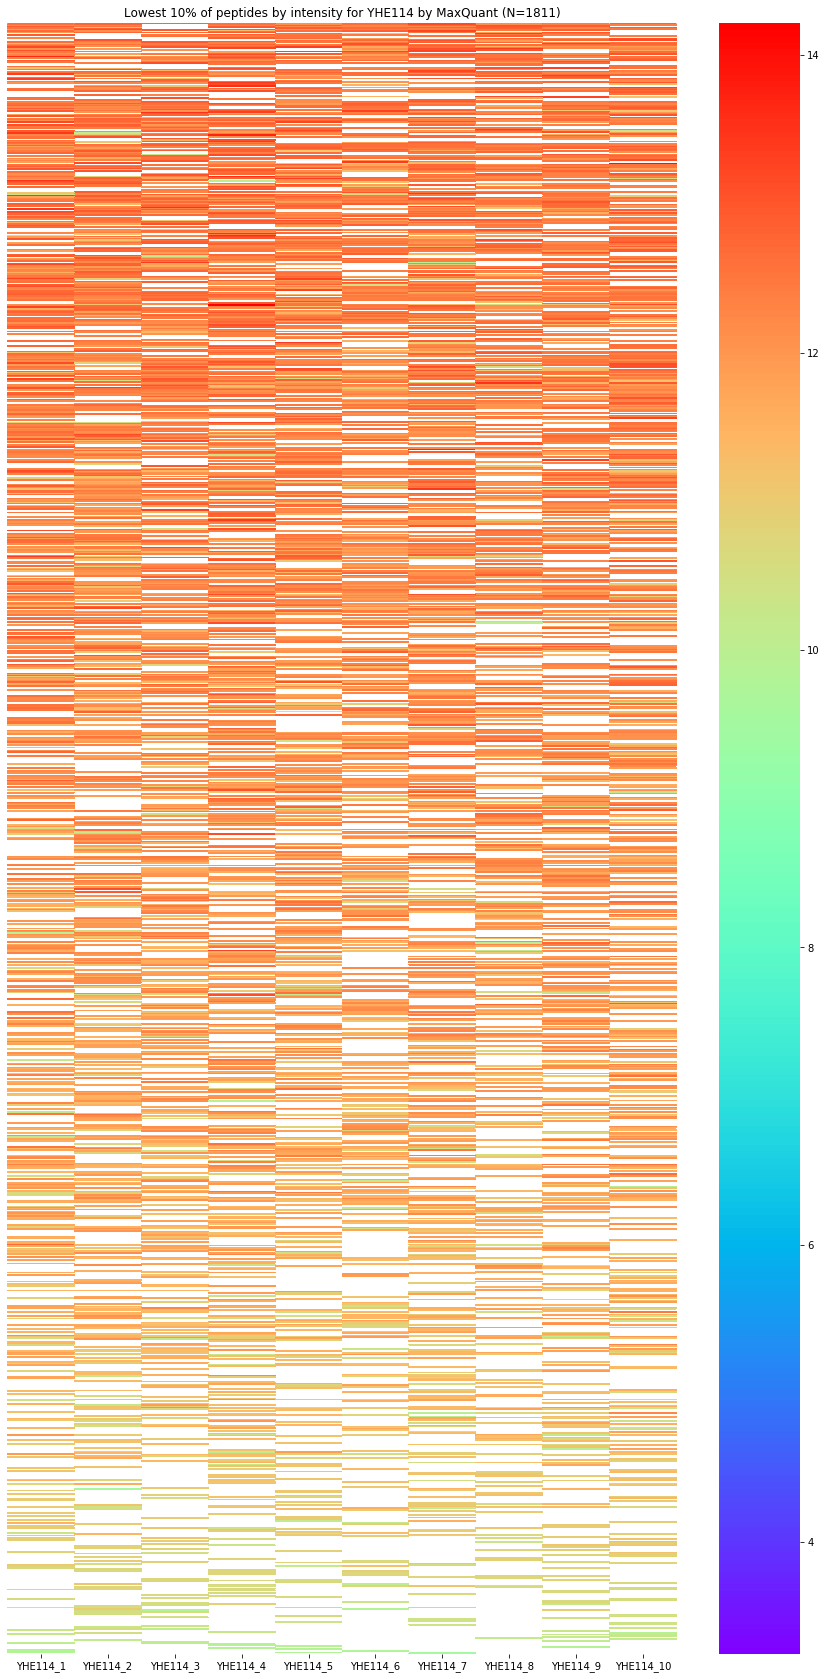

In [59]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap='rainbow', vmin=np.log2(a[a > 0].min()), mask=(occurences_df==0))
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {}% of peptides by intensity for YHE114 by MaxQuant (N={})'.format(int(lower_proportion*100), len(occurences_df)))

#### plot YHE211

In [60]:
run_names_l = sorted(list(mq_sequences_df[mq_sequences_df.group == 'YHE211'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [61]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe211_lowest_df.itertuples():
    run_occurences_df = mq_sequences_df[(mq_sequences_df.sequence == row.sequence) & (mq_sequences_df.modifications == row.modifications) & (mq_sequences_df.charge == row.charge) & (mq_sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1, 'Lowest 10% of peptides by intensity for YHE211 by MaxQuant (N=1833)')

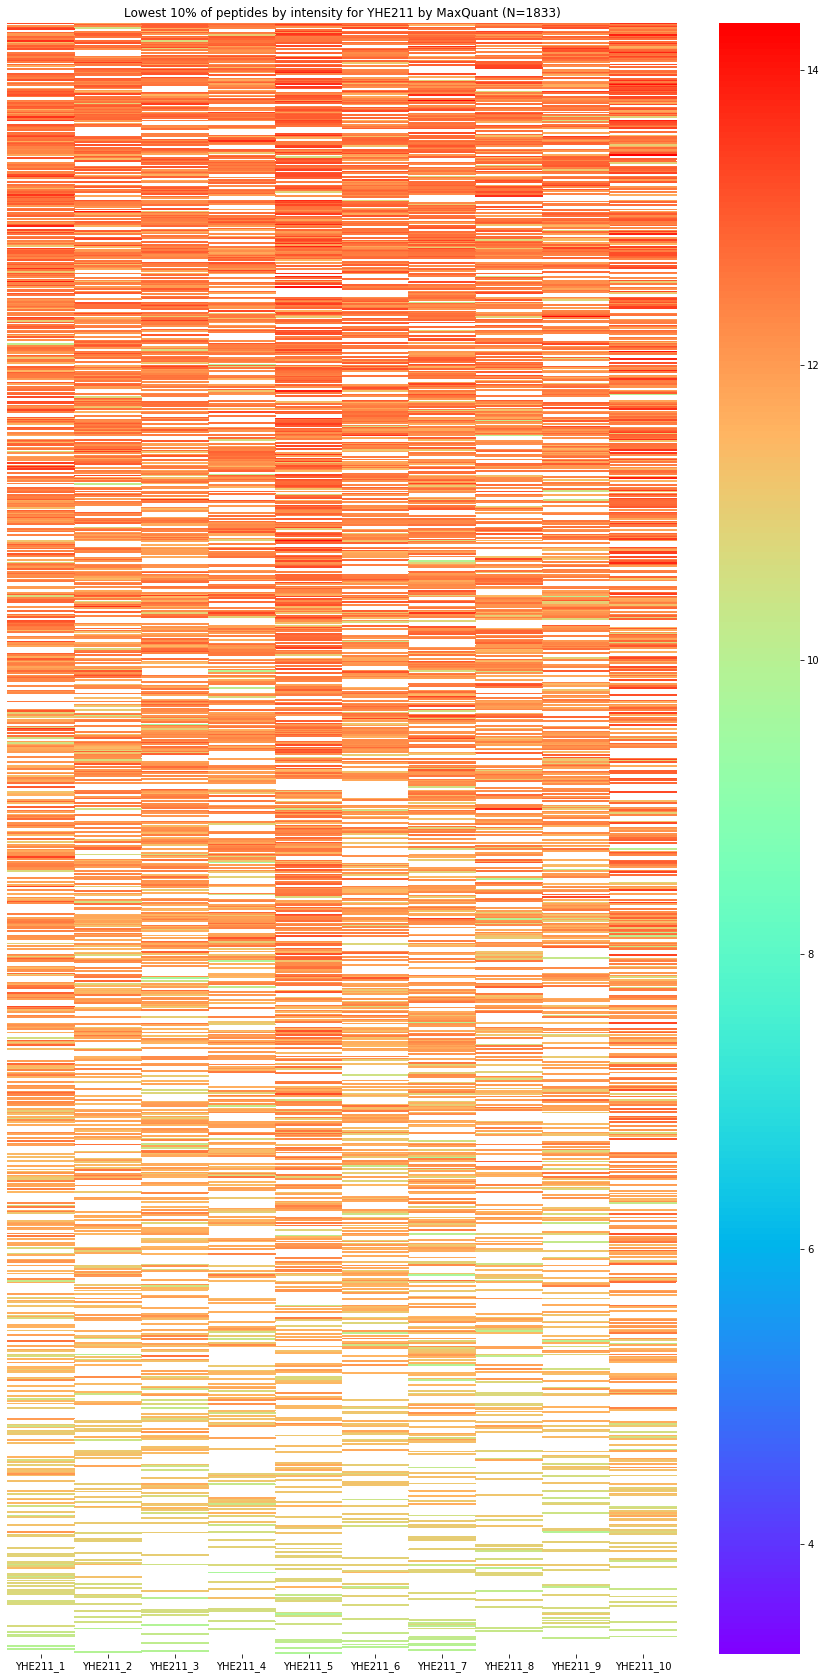

In [62]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap='rainbow', vmin=np.log2(a[a > 0].min()), mask=(occurences_df==0))
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {}% of peptides by intensity for YHE211 by MaxQuant (N={})'.format(int(lower_proportion*100), len(occurences_df)))

## Fragger heatmaps

In [63]:
# use the analysis with MBR
fragger_results_df = pd.read_csv('{}/MSstats-P3856.csv'.format(EXPERIMENT_DIR), sep=',')

In [64]:
fragger_sequences_df = fragger_results_df.copy()
fragger_sequences_df.columns

Index(['ProteinName', 'PeptideSequence', 'PrecursorCharge', 'FragmentIon',
       'ProductCharge', 'IsotopeLabelType', 'Condition', 'BioReplicate', 'Run',
       'Intensity'],
      dtype='object')

In [65]:
fragger_sequences_df['short_run_name'] = fragger_sequences_df.apply(lambda row: '_'.join(row.Run.split('_Slot')[0].split('_')[1:3]), axis=1)

In [66]:
fragger_sequences_df = fragger_sequences_df[fragger_sequences_df.Intensity.notnull()]
fragger_sequences_df = fragger_sequences_df[fragger_sequences_df.Intensity > 0]

In [67]:
fragger_sequences_df.sample(n=3)

,ProteinName,PeptideSequence,PrecursorCharge,FragmentIon,ProductCharge,IsotopeLabelType,Condition,BioReplicate,Run,Intensity,short_run_name
301592,sp|P38919|IF4A3_HUMAN,GRDVIAQSQSGTGK,2,NaN,NaN,L,YHE010,2,P3856_YHE010_2_Slot1-1_1_5094,9477.355,YHE010_2
537431,sp|Q53H12|AGK_HUMAN,IPIGFIPLGETSSLSHTLFAESGNK,3,NaN,NaN,L,YHE114,1,P3856_YHE114_1_Slot1-1_1_5115,61616.723,YHE114_1
218426,sp|P22830|HEMH_HUMAN,VGPMPWLGPQTDESIK,2,NaN,NaN,L,YHE211,6,P3856_YHE211_6_Slot1-1_1_5109,29080.162,YHE211_6


In [68]:
# find the mean intensity for each peptide in each group
fragger_intensities_l = []
for group_name,group_df in fragger_sequences_df.groupby(['PeptideSequence','PrecursorCharge','Condition'], as_index=False):
    mean_intensity = group_df.Intensity.mean()
    fragger_intensities_l.append((group_name[0], group_name[1], group_name[2], mean_intensity))
fragger_intensities_df = pd.DataFrame(fragger_intensities_l, columns=['sequence', 'charge', 'group', 'group_mean_intensity'])

In [69]:
# sort each group by descending intensity
fragger_intensities_df.sort_values(by=['group_mean_intensity'], ascending=False, inplace=True)

In [70]:
fragger_intensities_df.tail()

,sequence,charge,group,group_mean_intensity
48241,VC[57.0215]NYVNWIQQTIAAN,2,YHE211,357.09050
43509,STSSETDC[57.0215]NDNVPSHK,2,YHE114,324.62850
39256,RDLPNALDEK,2,YHE010,290.59800
14658,FNLSVIEDPSMK,2,YHE211,247.62599
137,AAGALLNGPPQFSTAPEIK,2,YHE010,214.77450


In [71]:
# make a separate DF for each group
yhe010_df = fragger_intensities_df[(fragger_intensities_df.group == 'YHE010')].copy()
yhe114_df = fragger_intensities_df[(fragger_intensities_df.group == 'YHE114')].copy()
yhe211_df = fragger_intensities_df[(fragger_intensities_df.group == 'YHE211')].copy()

In [72]:
# find the lowest-intensity peptides in each group
lower_proportion = 0.1
yhe010_lowest_df = yhe010_df.tail(int(lower_proportion * len(yhe010_df)))
yhe114_lowest_df = yhe114_df.tail(int(lower_proportion * len(yhe114_df)))
yhe211_lowest_df = yhe211_df.tail(int(lower_proportion * len(yhe211_df)))

#### plot YHE010

In [73]:
run_names_l = sorted(list(fragger_sequences_df[fragger_sequences_df.Condition == 'YHE010'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [74]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe010_lowest_df.itertuples():
    run_occurences_df = fragger_sequences_df[(fragger_sequences_df.PeptideSequence == row.sequence) & (fragger_sequences_df.PrecursorCharge == row.charge) & (fragger_sequences_df.Condition == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.Intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1, 'Lowest 10% of peptides by intensity for YHE010 by MSFragger (N=1785)')

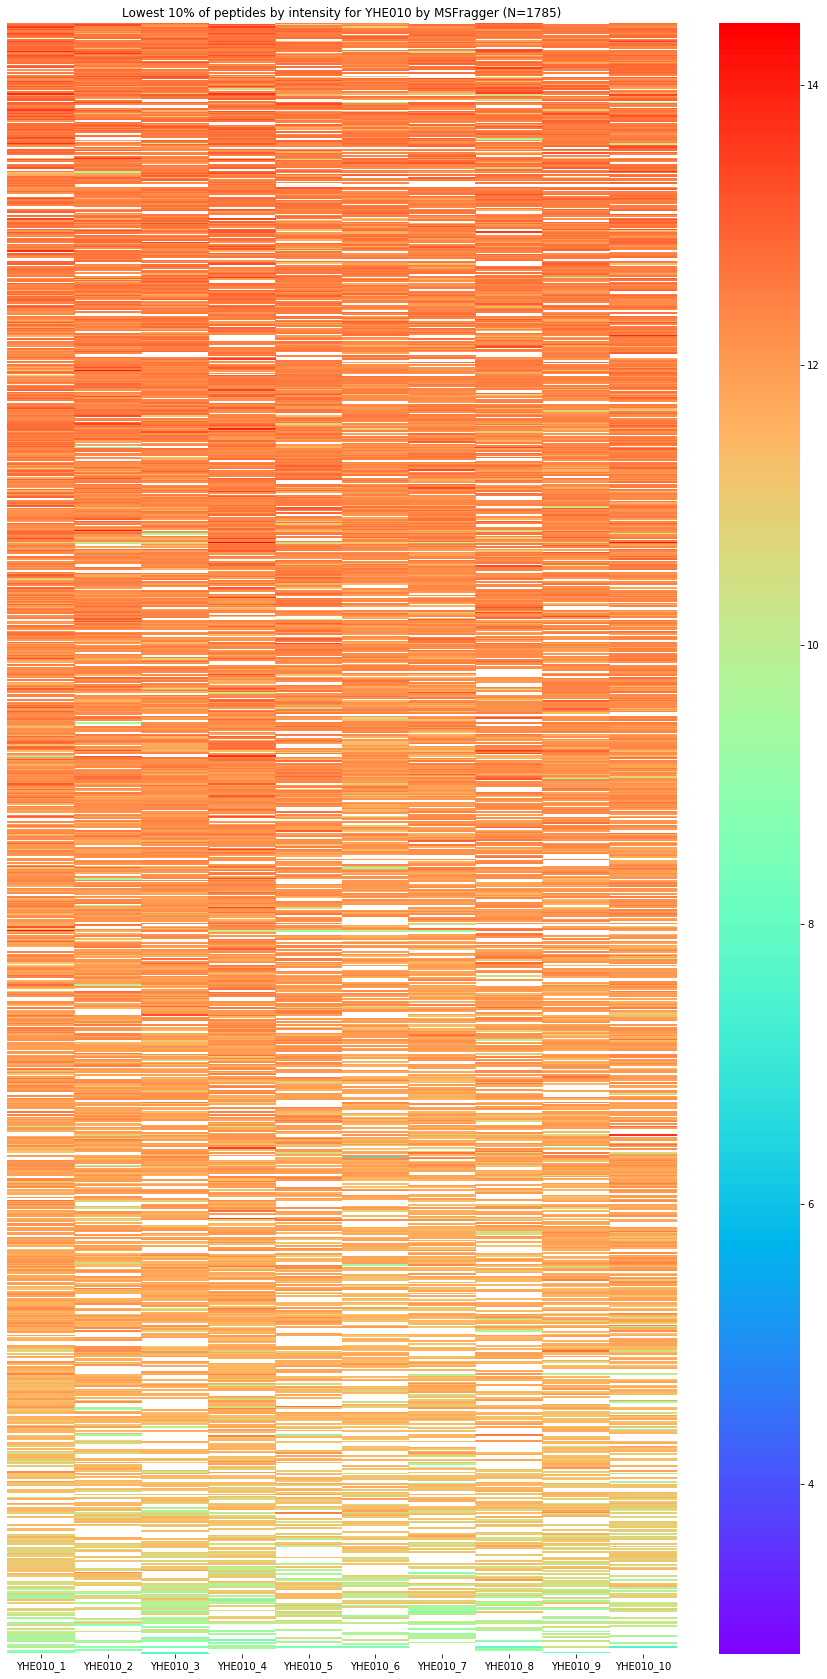

In [75]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap='rainbow', vmin=np.log2(a[a > 0].min()), mask=(occurences_df==0))
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {}% of peptides by intensity for YHE010 by MSFragger (N={})'.format(int(lower_proportion*100), len(occurences_df)))

#### plot YHE114

In [76]:
run_names_l = sorted(list(fragger_sequences_df[fragger_sequences_df.Condition == 'YHE114'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [77]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe114_lowest_df.itertuples():
    run_occurences_df = fragger_sequences_df[(fragger_sequences_df.PeptideSequence == row.sequence) & (fragger_sequences_df.PrecursorCharge == row.charge) & (fragger_sequences_df.Condition == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.Intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1, 'Lowest 10% of peptides by intensity for YHE114 by MSFragger (N=1887)')

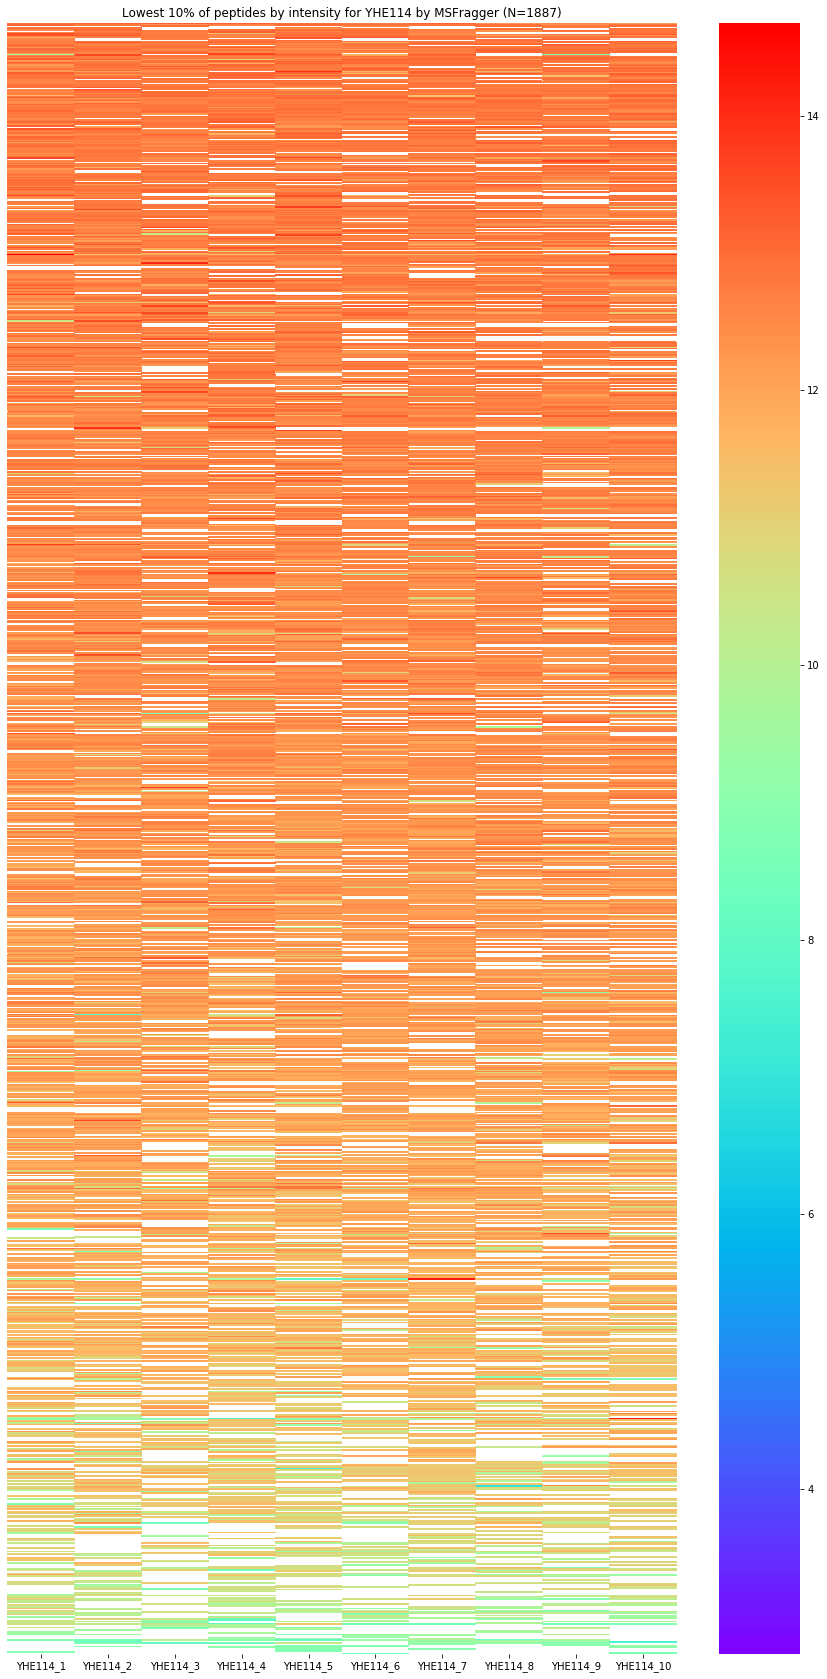

In [78]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap='rainbow', vmin=np.log2(a[a > 0].min()), mask=(occurences_df==0))
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {}% of peptides by intensity for YHE114 by MSFragger (N={})'.format(int(lower_proportion*100), len(occurences_df)))

#### plot YHE211

In [79]:
run_names_l = sorted(list(fragger_sequences_df[fragger_sequences_df.Condition == 'YHE211'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [80]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe211_lowest_df.itertuples():
    run_occurences_df = fragger_sequences_df[(fragger_sequences_df.PeptideSequence == row.sequence) & (fragger_sequences_df.PrecursorCharge == row.charge) & (fragger_sequences_df.Condition == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.Intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1, 'Lowest 10% of peptides by intensity for YHE211 by MaxQuant (N=1935)')

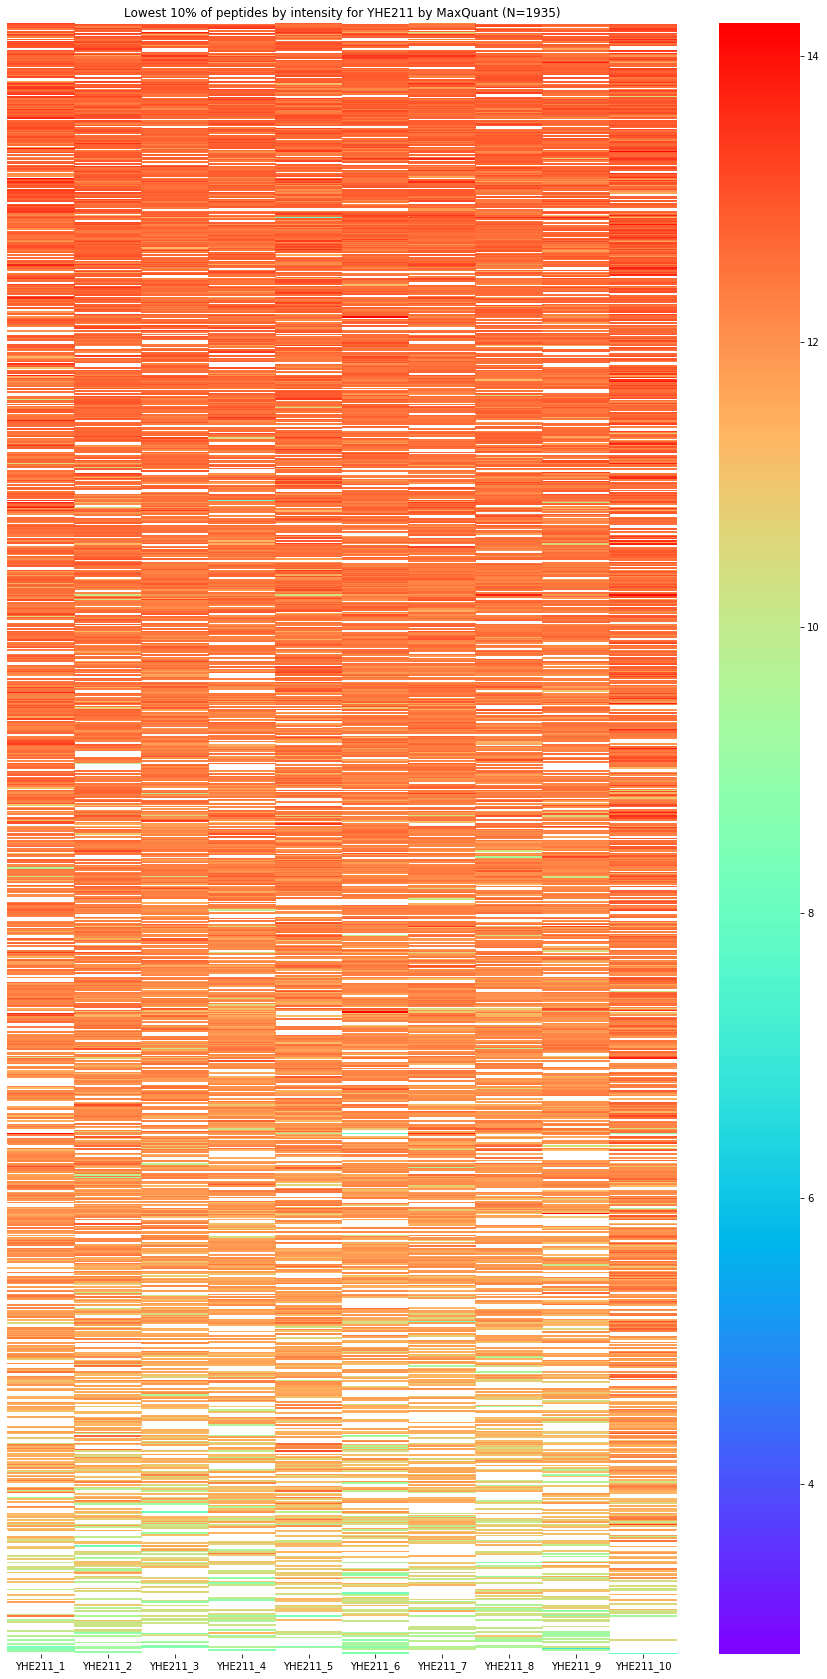

In [81]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap='rainbow', vmin=np.log2(a[a > 0].min()), mask=(occurences_df==0))
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {}% of peptides by intensity for YHE211 by MaxQuant (N={})'.format(int(lower_proportion*100), len(occurences_df)))

## visualise the percentage of missing values across runs

#### prepare TFD/E results

In [293]:
subset_groups = ['YHE114']

In [294]:
tfde_subset_df = sequences_df[(sequences_df.group.isin(subset_groups))]

In [295]:
number_of_runs_in_subset = len(tfde_subset_df.short_run_name.unique())
print('there are {} {} runs in the experiment'.format(number_of_runs_in_subset, subset_groups))

there are 10 ['YHE114'] runs in the experiment


In [296]:
number_of_unique_sequences_tfde = len(tfde_subset_df.drop_duplicates(subset=['sequence', 'charge'], keep='first', inplace=False))
number_of_unique_sequences_tfde

22503

In [297]:
# count how many runs each sequence/charge was extracted from and classified as a target
sequence_occurences_l = []
for group_name,group_df in tfde_subset_df.groupby(['sequence','charge'], as_index=False):
    sequence_occurences_l.append((group_name, len(group_df.short_run_name.unique()), group_name[0], group_name[1]))
tfde_sequence_occurences_df = pd.DataFrame(sequence_occurences_l, columns=['sequence_charge','number_of_runs_extracted','sequence','charge'])

In [298]:
tfde_sequence_occurences_df['missing_files'] = number_of_runs_in_subset - tfde_sequence_occurences_df.number_of_runs_extracted

In [299]:
# display the number of missing values across the subset
tfde_missing_values = tfde_sequence_occurences_df.missing_files.sum() / (len(tfde_sequence_occurences_df) * number_of_runs_in_subset)

In [300]:
tfde_sequence_occurences_df.sample(n=3)

,sequence_charge,number_of_runs_extracted,sequence,charge,missing_files
21644,"(WVVFDGPIDTLWIESMNTVLDDNK, 3)",2,WVVFDGPIDTLWIESMNTVLDDNK,3,8
20012,"(VEQMFQILLDPEEK, 2)",9,VEQMFQILLDPEEK,2,1
19847,"(VDHLANYSADFVSK, 2)",10,VDHLANYSADFVSK,2,0


In [301]:
run_count_l = []
for number_of_runs in range(1,number_of_runs_in_subset+1):
    run_count_l.append((number_of_runs, len(tfde_sequence_occurences_df[tfde_sequence_occurences_df.number_of_runs_extracted >= number_of_runs])))
tfde_run_count_df = pd.DataFrame(run_count_l, columns=['run_count','number_of_sequences'])

In [302]:
tfde_run_count_df['percent_quantified'] = tfde_run_count_df.number_of_sequences / number_of_unique_sequences_tfde * 100

#### prepare MQ results

In [303]:
mq_sequences_df.columns

Index(['sequence', 'modifications', 'charge', 'short_run_name', 'group',
       'identified_in_file', 'score', 'intensity'],
      dtype='object')

In [304]:
mq_subset_df = mq_sequences_df[(mq_sequences_df.group.isin(subset_groups))]

In [305]:
number_of_unique_sequences_mq = len(mq_subset_df.drop_duplicates(subset=['sequence','modifications','charge'], keep='first', inplace=False))
number_of_unique_sequences_mq

18112

In [306]:
# count how many runs each sequence/charge was extracted from
sequence_occurences_l = []
for group_name,group_df in mq_subset_df.groupby(['sequence', 'modifications', 'charge'], as_index=False):
    sequence_occurences_l.append((group_name[0], group_name[1], group_name[2], len(group_df.short_run_name.unique())))
mq_sequence_occurences_df = pd.DataFrame(sequence_occurences_l, columns=['sequence','modifications','charge','number_of_runs_extracted'])

In [307]:
run_count_l = []
for number_of_runs in range(1,number_of_runs_in_subset+1):
    run_count_l.append((number_of_runs, len(mq_sequence_occurences_df[mq_sequence_occurences_df.number_of_runs_extracted >= number_of_runs])))
mq_run_count_df = pd.DataFrame(run_count_l, columns=['run_count','number_of_sequences'])

In [308]:
mq_sequence_occurences_df['missing_files'] = number_of_runs_in_subset - mq_sequence_occurences_df.number_of_runs_extracted
mq_run_count_df['percent_quantified'] = mq_run_count_df.number_of_sequences / number_of_unique_sequences_mq * 100

In [309]:
# display the number of missing values across the subset
mq_missing_values = mq_sequence_occurences_df.missing_files.sum() / (len(mq_sequence_occurences_df) * number_of_runs_in_subset)

#### prepare Fragger results

In [310]:
fragger_subset_df = fragger_sequences_df[(fragger_sequences_df.Condition.isin(subset_groups))]

In [311]:
number_of_unique_sequences_fragger = len(fragger_subset_df.drop_duplicates(subset=['PeptideSequence', 'PrecursorCharge'], keep='first', inplace=False))
number_of_unique_sequences_fragger

18878

In [312]:
# count how many runs each sequence/charge was found in
sequence_occurences_l = []
for group_name,group_df in fragger_subset_df.groupby(['PeptideSequence','PrecursorCharge'], as_index=False):
    sequence_occurences_l.append((group_name[0], group_name[1], len(group_df.short_run_name.unique())))
fragger_sequence_occurences_df = pd.DataFrame(sequence_occurences_l, columns=['sequence','charge','number_of_runs_extracted'])

In [313]:
run_count_l = []
for number_of_runs in range(1,number_of_runs_in_subset+1):
    run_count_l.append((number_of_runs, len(fragger_sequence_occurences_df[fragger_sequence_occurences_df.number_of_runs_extracted >= number_of_runs])))
fragger_run_count_df = pd.DataFrame(run_count_l, columns=['run_count','number_of_sequences'])

In [314]:
fragger_sequence_occurences_df['missing_files'] = number_of_runs_in_subset - fragger_sequence_occurences_df.number_of_runs_extracted
fragger_run_count_df['percent_quantified'] = fragger_run_count_df.number_of_sequences / number_of_unique_sequences_fragger * 100

In [315]:
# display the number of missing values across the subset
fragger_missing_values = fragger_sequence_occurences_df.missing_files.sum() / (len(fragger_sequence_occurences_df) * number_of_runs_in_subset)

#### now plot the results

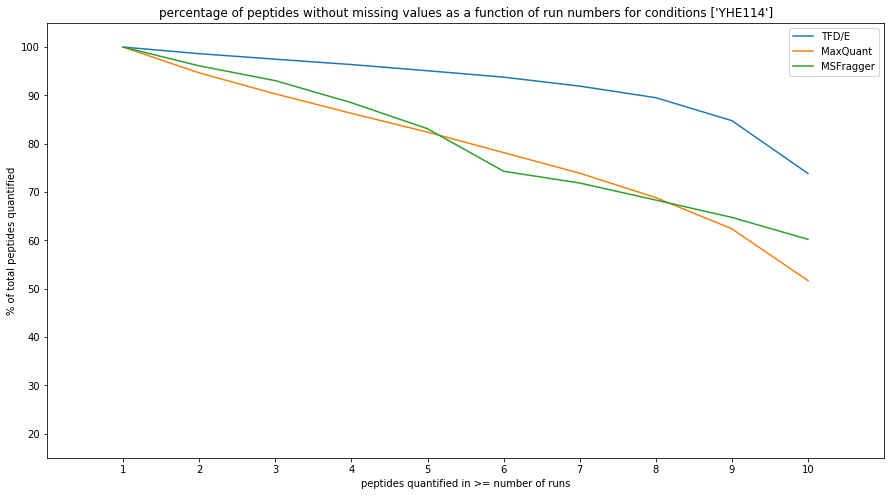

In [316]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('percentage of peptides without missing values as a function of run numbers for conditions {}'.format(subset_groups))

ax1.plot(tfde_run_count_df.run_count, tfde_run_count_df.percent_quantified, label='TFD/E')
ax1.plot(mq_run_count_df.run_count, mq_run_count_df.percent_quantified, label='MaxQuant')
ax1.plot(fragger_run_count_df.run_count, fragger_run_count_df.percent_quantified, label='MSFragger')

plt.xlabel('peptides quantified in >= number of runs')
plt.ylabel('% of total peptides quantified')
plt.ylim((15,105))
ax1.set(xticks=range(1,number_of_runs_in_subset+1), xlim=[0, number_of_runs_in_subset+1])
plt.legend(loc="best")

plt.show()

## missing-ness distributions

#### plot TFD/E results

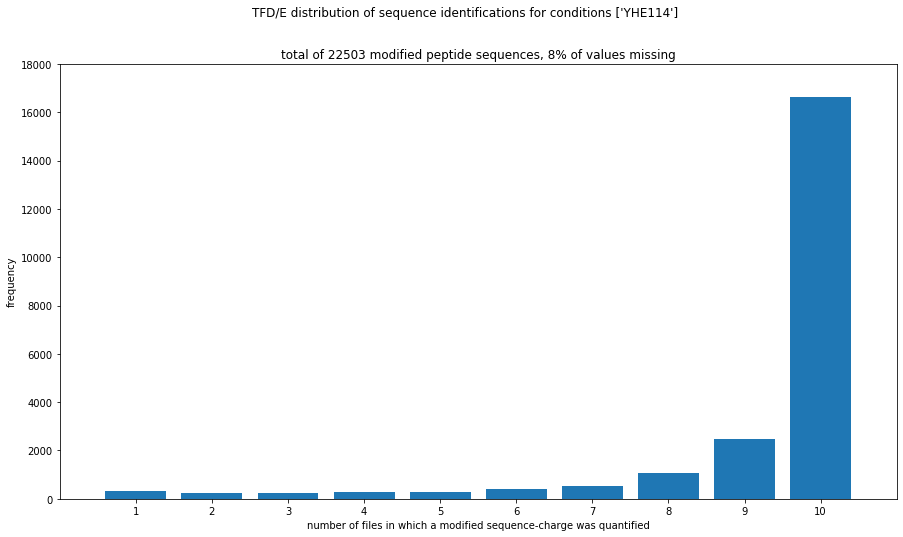

In [317]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.suptitle('TFD/E distribution of sequence identifications for conditions {}'.format(subset_groups))
plt.title('total of {} modified peptide sequences, {}% of values missing'.format(number_of_unique_sequences_tfde, int(round(tfde_missing_values*100))))

counts = np.bincount(tfde_sequence_occurences_df.number_of_runs_extracted)
ax1.bar(range(number_of_runs_in_subset+1), counts, width=0.8, align='center')
plt.xlabel('number of files in which a modified sequence-charge was quantified')
plt.ylabel('frequency')
ax1.set(xticks=range(1,number_of_runs_in_subset+1), xlim=[0, number_of_runs_in_subset+1])
plt.ylim((0,18000))

plt.show()

#### plot MQ results

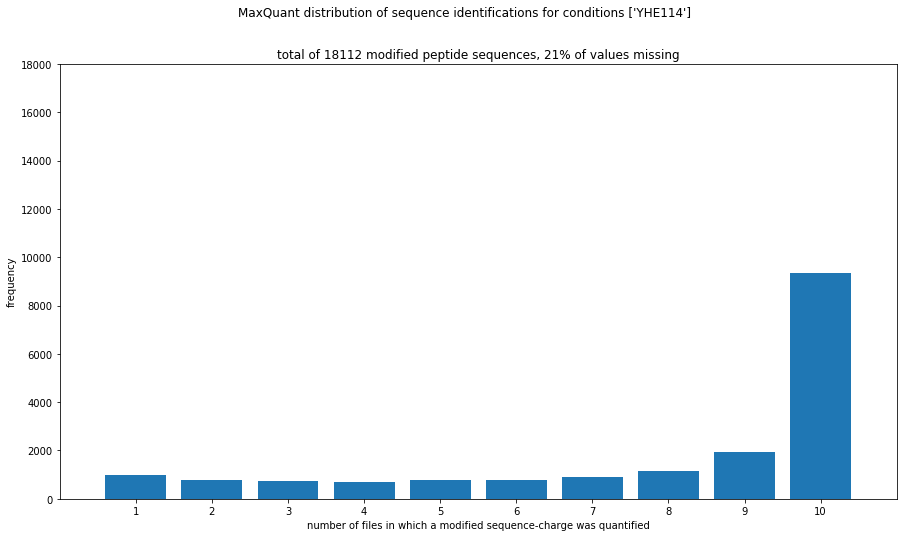

In [318]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.suptitle('MaxQuant distribution of sequence identifications for conditions {}'.format(subset_groups))
plt.title('total of {} modified peptide sequences, {}% of values missing'.format(number_of_unique_sequences_mq, int(round(mq_missing_values*100))))

counts = np.bincount(mq_sequence_occurences_df.number_of_runs_extracted)
ax1.bar(range(number_of_runs_in_subset+1), counts, width=0.8, align='center')
plt.xlabel('number of files in which a modified sequence-charge was quantified')
plt.ylabel('frequency')
ax1.set(xticks=range(1,number_of_runs_in_subset+1), xlim=[0, number_of_runs_in_subset+1])
plt.ylim((0,18000))

plt.show()

#### plot Fragger results

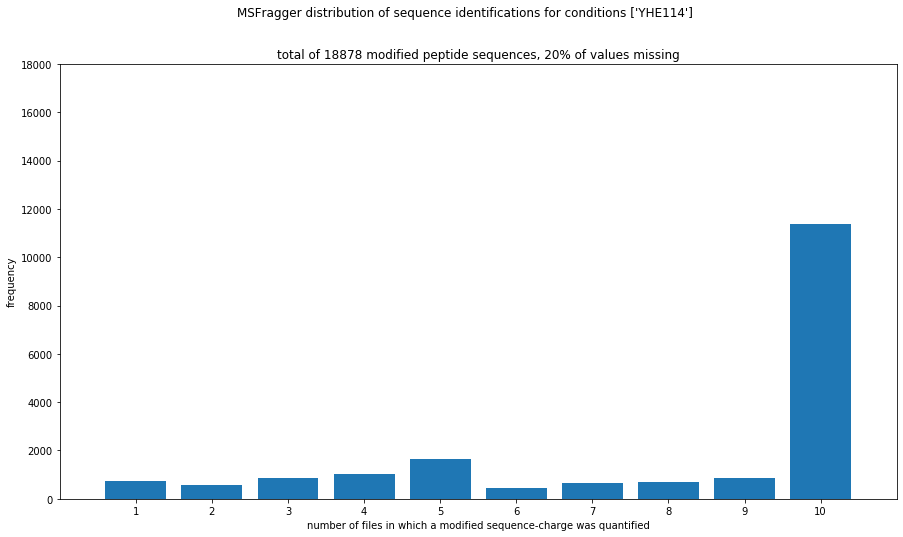

In [319]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.suptitle('MSFragger distribution of sequence identifications for conditions {}'.format(subset_groups))
plt.title('total of {} modified peptide sequences, {}% of values missing'.format(number_of_unique_sequences_fragger, int(round(fragger_missing_values*100))))

counts = np.bincount(fragger_sequence_occurences_df.number_of_runs_extracted)
ax1.bar(range(number_of_runs_in_subset+1), counts, width=0.8, align='center')
plt.xlabel('number of files in which a modified sequence-charge was quantified')
plt.ylabel('frequency')
ax1.set(xticks=range(1,number_of_runs_in_subset+1), xlim=[0, number_of_runs_in_subset+1])
plt.ylim((0,18000))

plt.show()

## distribution of quantitative intensities

#### prepare TFD/E results

In [320]:
tfde_subset_df.sample(n=3)

,sequence,charge,id_perc_q_value,short_run_name,group,intensity
32269,AQHQQALSSLELLNVLFR,3,0.000004,YHE114_4,YHE114,390
275411,LHEWEDALVAYDK,2,0.000080,YHE114_9,YHE114,665
161619,GEGFMVVTATGDNTFVGR,2,0.000004,YHE114_8,YHE114,782


In [321]:
# calculate the intensity mean for peptides without missing values
tfde_intensities_l = []
for group_name,group_df in tfde_subset_df.groupby(['sequence','charge'], as_index=False):
    if len(group_df.short_run_name.unique()) == number_of_runs_in_subset:
        intensity_mean = group_df.intensity.mean()
        tfde_intensities_l.append((','.join([group_name[0],group_name[1].astype('str')]),intensity_mean,'TFD/E'))
tfde_intensities_df = pd.DataFrame(tfde_intensities_l, columns=['sequence','intensity','method'])
tfde_intensities_df['intensity_adjusted'] = tfde_intensities_df.intensity - np.min(tfde_intensities_df.intensity)
tfde_intensities_df.intensity_adjusted.replace(to_replace=[0.0], value=1.0, inplace=True)

#### prepare MQ results

In [322]:
mq_subset_df.sample(n=3)

,sequence,modifications,charge,short_run_name,group,identified_in_file,score,intensity
330031,SVTSNQSDGTQESCESPDVLDR,Unmodified,2,YHE114_2,YHE114,True,54.813,47658.0
254248,NENCVEETFEDLLLK,Unmodified,2,YHE114_1,YHE114,False,194.700,17129.0
53790,DLIPIFEEALSSSTDSALK,Unmodified,2,YHE114_9,YHE114,True,45.170,20159.0


In [323]:
# calculate the intensity mean for peptides without missing values
mq_intensities_l = []
for group_name,group_df in mq_subset_df.groupby(['sequence','modifications','charge'], as_index=False):
    if len(group_df.short_run_name.unique()) == number_of_runs_in_subset:
        intensity_mean = group_df.intensity.mean()
        mq_intensities_l.append((','.join([group_name[0],group_name[1],group_name[2].astype('str')]),intensity_mean,'MaxQuant'))
mq_intensities_df = pd.DataFrame(mq_intensities_l, columns=['sequence','intensity','method'])
mq_intensities_df['intensity_adjusted'] = mq_intensities_df.intensity - np.min(mq_intensities_df.intensity)
mq_intensities_df.intensity_adjusted.replace(to_replace=[0.0], value=1.0, inplace=True)

#### prepare Fragger results

In [324]:
fragger_subset_df.sample(n=3)

,ProteinName,PeptideSequence,PrecursorCharge,FragmentIon,ProductCharge,IsotopeLabelType,Condition,BioReplicate,Run,Intensity,short_run_name
70151,sp|O95456|PSMG1_HUMAN,DSAC[57.0215]C[57.0215]PLLEQPNIVHDLPAAVLSYC[57...,3,NaN,NaN,L,YHE114,1,P3856_YHE114_1_Slot1-1_1_5115,58289.250,YHE114_1
107267,sp|P06169|PDC1_YEAST,TTYVTQRPVYLGLPANLVDLNVPAK,3,NaN,NaN,L,YHE114,7,P3856_YHE114_7_Slot1-1_1_5121,146611.520,YHE114_7
241720,sp|P28074|PSB5_HUMAN,VSSDNVADLHEK,2,NaN,NaN,L,YHE114,10,P3856_YHE114_10_Slot1-1_1_5124,8113.406,YHE114_10


In [325]:
# calculate the intensity mean for peptides without missing values
fragger_intensities_l = []
for group_name,group_df in fragger_subset_df.groupby(['PeptideSequence', 'PrecursorCharge'], as_index=False):
    if len(group_df['Run'].unique()) == number_of_runs_in_subset:
        intensity_mean = group_df.Intensity.mean()
        fragger_intensities_l.append((','.join([group_name[0],group_name[1].astype('str')]),intensity_mean,'MSFragger'))
fragger_intensities_df = pd.DataFrame(fragger_intensities_l, columns=['sequence','intensity','method'])
fragger_intensities_df['intensity_adjusted'] = fragger_intensities_df.intensity - np.min(fragger_intensities_df.intensity)
fragger_intensities_df.intensity_adjusted.replace(to_replace=[0.0], value=1.0, inplace=True)

In [326]:
tfde_intensities_df['intensity_log'] = np.log10(tfde_intensities_df.intensity)
mq_intensities_df['intensity_log'] = np.log10(mq_intensities_df.intensity)
fragger_intensities_df['intensity_log'] = np.log10(fragger_intensities_df.intensity)

In [327]:
tfde_intensities_df['intensity_adjusted_log'] = tfde_intensities_df.intensity_log - np.min(tfde_intensities_df.intensity_log)
mq_intensities_df['intensity_adjusted_log'] = mq_intensities_df.intensity_log - np.min(mq_intensities_df.intensity_log)
fragger_intensities_df['intensity_adjusted_log'] = fragger_intensities_df.intensity_log - np.min(fragger_intensities_df.intensity_log)

#### consolidate the data

In [328]:
intensities_l = [tfde_intensities_df,mq_intensities_df,fragger_intensities_df]
intensities_df = pd.concat(intensities_l, sort=False)

In [329]:
intensities_df.sample(n=3)

,sequence,intensity,method,intensity_adjusted,intensity_log,intensity_adjusted_log
4440,"IEALGGFVSHMDC[57.0215]WR,2",28179.0598,MSFragger,25471.75966,4.449926,1.017390
16402,"YPIEHGIVTNWDDMEK,2",9829.6000,TFD/E,9649.10000,3.992536,1.736059
4415,"FPAYLQQLSMESNGK,2",7364.5000,TFD/E,7184.00000,3.867143,1.610666


#### produce the plot

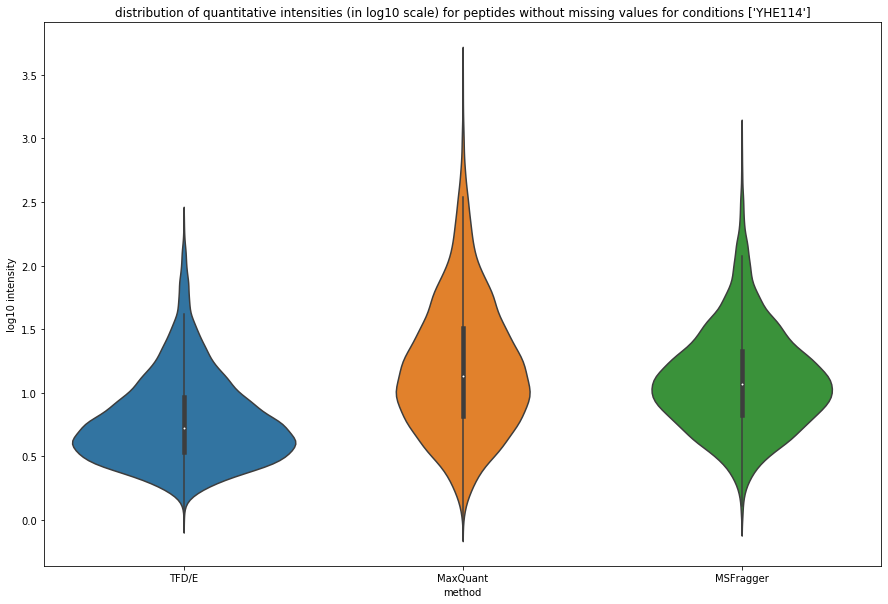

In [330]:
plt.figure(figsize=(15,10))
ax = sns.violinplot(x=intensities_df.method, y=intensities_df.intensity_adjusted_log)
_ = plt.ylabel("log10 intensity")
_ = plt.title('distribution of quantitative intensities (in log10 scale) for peptides without missing values for conditions {}'.format(subset_groups))

In [331]:
# orders of magnitude
intensities_df.groupby('method')['intensity_adjusted_log'].agg(np.ptp)

/Users/darylwilding-mcbride/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


method
MSFragger    3.023449
MaxQuant     3.552658
TFD/E        2.362198
Name: intensity_adjusted_log, dtype: float64

In [332]:
# number of peptides that have no missing values
intensities_df.groupby('method')['intensity_adjusted_log'].count()

method
MSFragger    11368
MaxQuant      9359
TFD/E        16617
Name: intensity_adjusted_log, dtype: int64

## distribution of CV

#### TFD/E analysis

In [333]:
# for each sequence, find the CV
sequence_cv_l = []
for group_name,group_df in tfde_subset_df.groupby(['sequence','charge']):
    if len(group_df.short_run_name.unique()) == number_of_runs_in_subset:
        intensity_cv = np.std(group_df.intensity) / np.mean(group_df.intensity)
        sequence_cv_l.append((group_name[0], group_name[1], intensity_cv))
sequence_cv_df = pd.DataFrame(sequence_cv_l, columns=['sequence','charge','intensity_cv'])

In [334]:
sequence_cv_df.sample(n=3)

,sequence,charge,intensity_cv
614,ALDMSYDHKPEDEVELAR,3,0.373206
1615,DAQGEESTINTPTGDESGEVVK,2,0.225041
15958,YADLTEDQLPSCESLK,2,0.058359


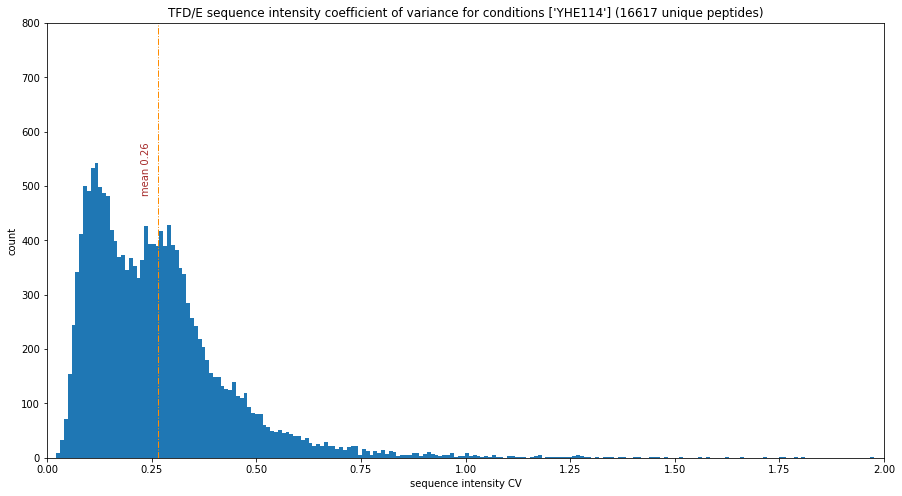

In [335]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 300
values = sequence_cv_df.intensity_cv
y, x, _ = ax1.hist(values, bins=bins)
mean = np.mean(values)
ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('sequence intensity CV')
plt.ylabel('count')
plt.title('TFD/E sequence intensity coefficient of variance for conditions {} ({} unique peptides)'.format(subset_groups,len(sequence_cv_df)))
plt.xlim((0,2))
plt.ylim((0,800))

plt.show()

#### MQ analysis

In [ ]:
# for each sequence, find the CV
sequence_cv_l = []
for group_name,group_df in mq_subset_df.groupby(['sequence','modifications','charge']):
    if len(group_df.short_run_name.unique()) == number_of_runs_in_subset:
        intensity_cv = np.std(group_df.intensity) / np.mean(group_df.intensity)
        sequence = ','.join([group_name[0],group_name[1],group_name[2].astype('str')])
        sequence_cv_l.append((sequence, intensity_cv))
mq_sequence_cv_df = pd.DataFrame(sequence_cv_l, columns=['sequence','intensity_cv'])

In [ ]:
mq_sequence_cv_df.sample(n=3)

In [ ]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 300
values = mq_sequence_cv_df.intensity_cv
y, x, _ = ax1.hist(values, bins=bins)
mean = np.mean(values)
ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('sequence intensity CV')
plt.ylabel('count')
plt.title('MaxQuant sequence intensity coefficient of variance for conditions {} ({} unique peptides)'.format(subset_groups, len(mq_sequence_cv_df)))
plt.xlim((0,2))
plt.ylim((0,800))

plt.show()

#### Fragger analysis

In [ ]:
# for each sequence, find the CV
sequence_cv_l = []
for group_name,group_df in fragger_subset_df.groupby(['PeptideSequence', 'PrecursorCharge']):
    if len(group_df['Run'].unique()) == number_of_runs_in_subset:
        intensity_cv = np.std(group_df.Intensity) / np.mean(group_df.Intensity)
        sequence = ','.join([group_name[0],group_name[1].astype('str')])
        sequence_cv_l.append((sequence, intensity_cv))
fragger_sequence_cv_df = pd.DataFrame(sequence_cv_l, columns=['sequence','intensity_cv'])

In [ ]:
fragger_sequence_cv_df.sample(n=3)

In [ ]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 300
values = fragger_sequence_cv_df.intensity_cv
y, x, _ = ax1.hist(values, bins=bins)
mean = np.mean(values)
ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('sequence intensity CV')
plt.ylabel('count')
plt.title('MSFragger sequence intensity coefficient of variance for conditions {} ({} unique peptides)'.format(subset_groups,len(fragger_sequence_cv_df)))
plt.xlim((0,2))
plt.ylim((0,800))

plt.show()